In [5]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

In [6]:
import os
import time
import uuid
import cv2

In [7]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [9]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\levir\.labelmerc
QBasicTimer::start: QBasicTimer can only be used with threads started with QThread


In [10]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

In [11]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experiemental.set_memory_growth(gpu, True)

In [12]:
tf.test.is_gpu_available('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [13]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [14]:
images.as_numpy_iterator().next()

b'data\\images\\72ba2efe-de36-11ec-99fc-0093379f732d.jpg'

In [15]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [16]:
images = images.map(load_image)

In [17]:
images.as_numpy_iterator().next()

array([[[43, 45, 42],
        [43, 45, 42],
        [43, 45, 42],
        ...,
        [43, 46, 55],
        [43, 46, 55],
        [43, 46, 55]],

       [[43, 45, 42],
        [43, 45, 42],
        [43, 45, 42],
        ...,
        [42, 45, 54],
        [43, 46, 55],
        [43, 46, 55]],

       [[43, 45, 42],
        [43, 45, 42],
        [43, 45, 42],
        ...,
        [42, 45, 54],
        [42, 45, 54],
        [43, 46, 55]],

       ...,

       [[42, 42, 44],
        [42, 42, 44],
        [42, 42, 44],
        ...,
        [43, 43, 45],
        [42, 43, 45],
        [42, 43, 45]],

       [[42, 41, 46],
        [42, 41, 46],
        [42, 42, 44],
        ...,
        [43, 43, 45],
        [42, 43, 45],
        [42, 43, 45]],

       [[42, 41, 46],
        [42, 41, 46],
        [42, 42, 44],
        ...,
        [42, 42, 44],
        [41, 42, 44],
        [41, 42, 44]]], dtype=uint8)

In [18]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [19]:
image_generator = images.batch(4).as_numpy_iterator()

In [20]:
plot_images = image_generator.next()

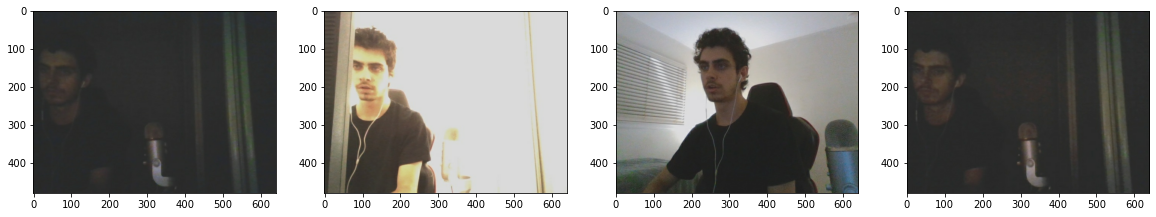

In [21]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [22]:
#63 = train, 14 = test, 13 = val

In [23]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

Albumentations Section:

In [24]:
import albumentations as alb

In [25]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [26]:
img = cv2.imread(os.path.join('data','train','images','2eb8ea60-dd41-11ec-86f4-0093379f732d.jpg'))

In [27]:
with open(os.path.join('data', 'train', 'labels', '2eb8ea60-dd41-11ec-86f4-0093379f732d.json'), 'r') as f:
    label = json.load(f)

In [28]:
label['shapes'][0]['points']

[[218.0, 8.0], [370.0, 208.0]]

In [29]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [30]:
coords

[218.0, 8.0, 370.0, 208.0]

In [31]:
coords = list(np.divide(coords, [640,480,640,480]))

In [32]:
coords

[0.340625, 0.016666666666666666, 0.578125, 0.43333333333333335]

In [33]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [34]:
augmented['bboxes'][0][2:]

(0.5555555555555556, 0.4111111111111111)

In [35]:
augmented['bboxes']

[(0.21777777777777776, 0.0, 0.5555555555555556, 0.4111111111111111)]

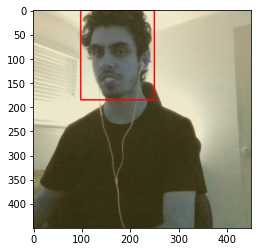

In [36]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Augmentation Pipeline:

In [37]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type


In [38]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [39]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [40]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [41]:
train_images.as_numpy_iterator().next()

array([[[0.13474265, 0.13474265, 0.13180147],
        [0.1382353 , 0.1382353 , 0.13039216],
        [0.13805147, 0.13805147, 0.13020833],
        ...,
        [0.4502451 , 0.4659314 , 0.4110294 ],
        [0.45919117, 0.46525735, 0.41047794],
        [0.47763482, 0.46734068, 0.41145834]],

       [[0.13235295, 0.13235295, 0.13137256],
        [0.14895834, 0.14895834, 0.14895834],
        [0.14454657, 0.14454657, 0.14454657],
        ...,
        [0.47248775, 0.4768995 , 0.42199755],
        [0.46243873, 0.4771446 , 0.41881126],
        [0.46262255, 0.4543505 , 0.40667892]],

       [[0.13872549, 0.13872549, 0.13088235],
        [0.14160539, 0.14160539, 0.14160539],
        [0.14748774, 0.14748774, 0.14748774],
        ...,
        [0.47144607, 0.46360293, 0.4047794 ],
        [0.4648897 , 0.44375   , 0.39522058],
        [0.4716912 , 0.4490196 , 0.41354167]],

       ...,

       [[0.8308211 , 0.8568627 , 0.86991423],
        [0.847549  , 0.8666667 , 0.877451  ],
        [0.8618873 , 0

Prepare Labels:

In [42]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [43]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [44]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [45]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [46]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.08  , 0.5864, 0.4177, 1.    ], dtype=float16))

In [47]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [49]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [50]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.4    , 0.     , 0.782  , 0.3977 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1912 , 0.11334, 0.4734 , 0.4866 ],
        [0.05554, 0.     , 0.8223 , 0.9287 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.4934 , 0.533  , 0.782  , 0.9688 ],
        [0.52   , 0.569  , 0.858  , 1.     ]], dtype=float16))

In [52]:
data_samples = train.as_numpy_iterator()

In [53]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


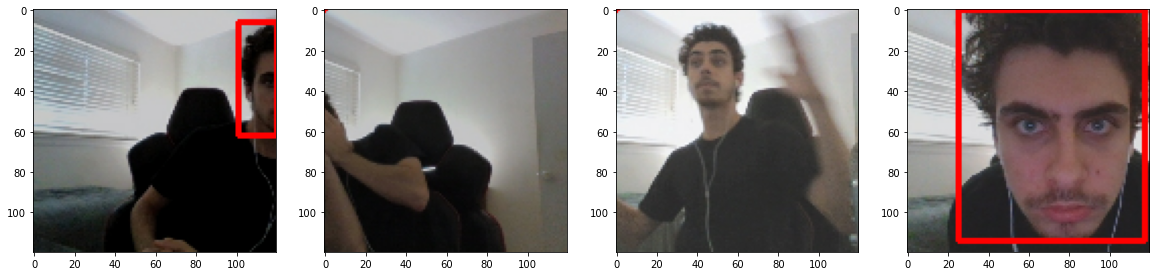

In [54]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [55]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [56]:
vgg = VGG16(include_top=False)

In [57]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [58]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [59]:
facetracker = build_model()

In [60]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [61]:
X, y = train.as_numpy_iterator().next()

In [62]:
X.shape

(8, 120, 120, 3)

In [63]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 293ms/step


In [64]:
classes, coords

(array([[0.5011613 ],
        [0.53091264],
        [0.52258027],
        [0.43835557],
        [0.4388815 ],
        [0.5387599 ],
        [0.4660273 ],
        [0.3943264 ]], dtype=float32),
 array([[0.49299935, 0.6012433 , 0.29789287, 0.5359242 ],
        [0.56156194, 0.6769205 , 0.24442905, 0.5535679 ],
        [0.45945683, 0.66361636, 0.4150403 , 0.5936009 ],
        [0.5424357 , 0.66570985, 0.30732453, 0.49186686],
        [0.5714982 , 0.6728843 , 0.35257915, 0.5394559 ],
        [0.52576137, 0.65790904, 0.33840474, 0.50941557],
        [0.5304123 , 0.66486716, 0.36302087, 0.5940242 ],
        [0.51429784, 0.6766625 , 0.38260016, 0.5490198 ]], dtype=float32))

In [65]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [66]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [67]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [68]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [69]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.678894>

In [70]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7520649>

In [71]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.678894>

In [72]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [73]:
model = FaceTracker(facetracker)

In [74]:
model.compile(opt, classloss, regressloss)

In [75]:
logdir='logs'

In [76]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [77]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
473/473 [==============================] - 346s 726ms/step - total_loss: 1.0217 - class_loss: 0.4199 - regress_loss: 0.8118 - val_total_loss: 0.8362 - val_class_loss: 0.5306 - val_regress_loss: 0.5709
Epoch 2/10
473/473 [==============================] - 363s 765ms/step - total_loss: 0.5812 - class_loss: 0.2673 - regress_loss: 0.4476 - val_total_loss: 0.6993 - val_class_loss: 0.4359 - val_regress_loss: 0.4814
Epoch 3/10
473/473 [==============================] - 363s 764ms/step - total_loss: 0.4615 - class_loss: 0.2117 - regress_loss: 0.3557 - val_total_loss: 0.2871 - val_class_loss: 0.1690 - val_regress_loss: 0.2026
Epoch 4/10
473/473 [==============================] - 369s 777ms/step - total_loss: 0.3876 - class_loss: 0.1798 - regress_loss: 0.2977 - val_total_loss: 0.3109 - val_class_loss: 0.2917 - val_regress_loss: 0.1651
Epoch 5/10
473/473 [==============================] - 371s 781ms/step - total_loss: 0.3841 - class_loss: 0.1797 - regress_loss: 0.2943 - val_total_loss:

In [78]:
hist.history

{'total_loss': [0.7725495100021362,
  0.6204967498779297,
  0.011760128661990166,
  0.26881885528564453,
  0.12795403599739075,
  0.4571766257286072,
  0.023608841001987457,
  0.3688645362854004,
  0.0012693811440840364,
  0.00848361011594534],
 'class_loss': [0.46689653396606445,
  0.3558509945869446,
  0.006884506903588772,
  0.19321200251579285,
  0.11805912107229233,
  0.28021931648254395,
  0.00980319082736969,
  0.3793700933456421,
  0.0005333386361598969,
  0.0009380619158037007],
 'regress_loss': [0.539101243019104,
  0.442571222782135,
  0.008317874744534492,
  0.1722128689289093,
  0.06892447918653488,
  0.3170669674873352,
  0.018707245588302612,
  0.17917950451374054,
  0.001002711826004088,
  0.008014579303562641],
 'val_total_loss': [0.8361597061157227,
  0.6992934942245483,
  0.2870806157588959,
  0.31094223260879517,
  0.21017968654632568,
  0.01018822193145752,
  0.1855229139328003,
  0.052732937037944794,
  0.11304334551095963,
  0.5989573001861572],
 'val_class_loss'

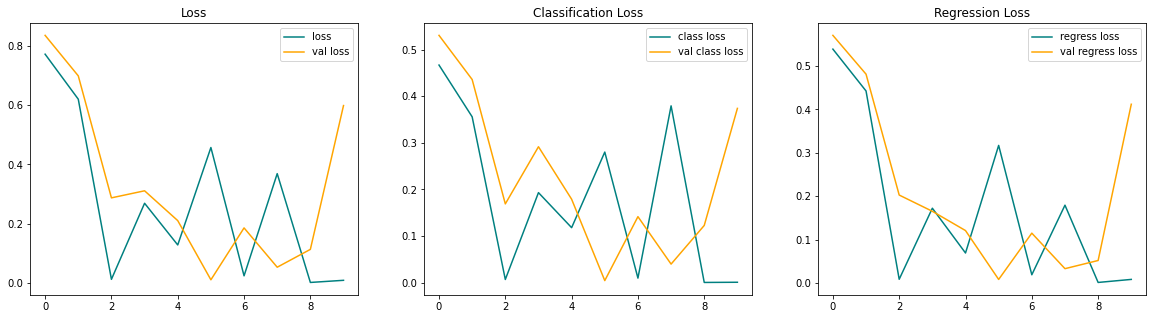

In [79]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [80]:
test_data = test.as_numpy_iterator()

In [81]:
test_sample = test_data.next()

In [82]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 188ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


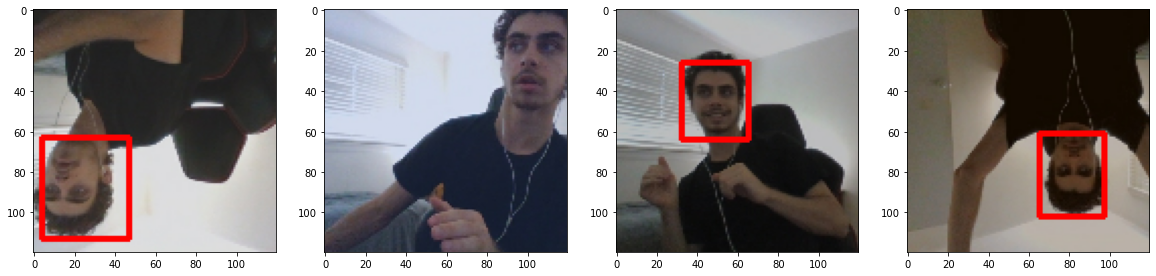

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [84]:
from tensorflow.keras.models import load_model

In [85]:
facetracker.save('facetracker.h5')

In [86]:
facetracker = load_model('facetracker.h5')

In [89]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 49ms/step
